In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scTRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Constants 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
OUT_PATH=DATA_PATH+'/results/fig_simu'

# GS 
gs = 'all_ngene1000'
DIC_GS_NAME = {'all_ngene500': 'random genes'}

# DATA_LIST
dname = 'tms_facs.ncell_10k'

# PERTURB_LIST
EFF_LIST = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
OVERLAP_LIST = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
PERTURB_LIST = []
PERTURB_FILE = 'tms_facs_ncell_10k.all_ngene1000.eff_@e_overlap_@o.perturb'
for eff in EFF_LIST:
    PERTURB_LIST.append(PERTURB_FILE.replace('@e', '%d'%int(eff*100)).replace('@o', '%d'%25))
for overlap in OVERLAP_LIST:
    PERTURB_LIST.append(PERTURB_FILE.replace('@e', '%d'%25).replace('@o', '%d'%int(overlap*100)))
# for eff in EFF_LIST:
#     for overlap in OVERLAP_LIST:
#         PERTURB_LIST.append(PERTURB_FILE.replace('@e', '%d'%int(eff*100)).replace('@o', '%d'%int(overlap*100)))

# Results 
DIC_RES_PATH = {'sctrs': DATA_PATH+'/simulation_data/score_file/@p',
                'seurat': DATA_PATH+'/simulation_data/score_file/@p',
                'vision': DATA_PATH+'/simulation_data/score_file/@p'}

METHOD_LIST = list(DIC_RES_PATH.keys())
DIC_METHOD_NAME = {'sctrs':'scDRS', 'seurat': 'Seurat', 'vision':'Vision', 'vam':'VAM'}
DIC_METHOD_COLOR = {'sctrs':'C0', 'seurat': 'C1', 'vision':'C2', 'vam':'C3'}

for method in METHOD_LIST:
    if method not in DIC_METHOD_NAME.keys():
        DIC_METHOD_NAME[method] = method
    if method not in DIC_METHOD_COLOR.keys():
        DIC_METHOD_COLOR[method] = 'C%d'%len(DIC_METHOD_COLOR)

In [3]:
# Read results 
import itertools
from sklearn import metrics

def get_performance(df_res, alt_cell_set, alpha_val=0.1, pval_col='pval'):
    # Get fdp and power at alpha=0.1
    v_fdr = multipletests(df_res[pval_col], method='fdr_bh')[1]
    rej_cell_set = set(df_res.index[v_fdr<=alpha_val])
    fdp = len(rej_cell_set - alt_cell_set) / max(len(rej_cell_set), 1)
    power = len(rej_cell_set & alt_cell_set) / len(alt_cell_set)
    # Also get AUC 
    v_true = np.array([x in alt_cell_set for x in df_res.index])
    auc_val = metrics.roc_auc_score(v_true, 1-df_res[pval_col])
    return fdp,power,auc_val

dic_res = {}
dic_res_auc = {}

df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file/%s.gs'%gs, sep='\t', index_col=0)
for perturb,method in itertools.product(PERTURB_LIST, METHOD_LIST):
    
    print(perturb,method)
    df_perturb = pd.read_csv(DATA_PATH+'/simulation_data/gs_file/%s'%perturb, sep='\t', index_col=0)
    dic_truth = {x:df_perturb.loc[x,'CELLLIST'].split(',') for x in df_perturb.index}
    trait_list = list(set(df_perturb.index) & set(df_gs.index))

    df_res = pd.DataFrame(index=df_gs.index, columns=['fdp', 'power', 'auc'], data=-1)

    # load scDRS result
    if 'sctrs' in method:
        for trait in trait_list:
            score_file = DIC_RES_PATH[method].replace('@p',perturb) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t', index_col=0)
                df_res.loc[trait] = get_performance(temp_df, set(dic_truth[trait]))
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s'%(perturb,method)] = df_res.copy()
            
    # load vision result        
    if method=='vision':
        for trait in trait_list:
            score_file = DIC_RES_PATH[method].replace('@p',perturb) + '/%s.vision.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t', index_col=0)
                df_res.loc[trait] = get_performance(temp_df, set(dic_truth[trait]), pval_col='norm_pval')
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s'%(perturb,method)] = df_res.copy()
        
    # load seurat results
    if method=='seurat':
        for trait in trait_list:
            score_file = DIC_RES_PATH[method].replace('@p',perturb) + '/%s.seurat.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t', index_col=0)
                df_res.loc[trait] = get_performance(temp_df, set(dic_truth[trait]))
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s'%(perturb,method)] = df_res.copy()

tms_facs_ncell_10k.all_ngene1000.eff_5_overlap_25.perturb sctrs
tms_facs_ncell_10k.all_ngene1000.eff_5_overlap_25.perturb seurat
tms_facs_ncell_10k.all_ngene1000.eff_5_overlap_25.perturb vision
tms_facs_ncell_10k.all_ngene1000.eff_10_overlap_25.perturb sctrs
tms_facs_ncell_10k.all_ngene1000.eff_10_overlap_25.perturb seurat
tms_facs_ncell_10k.all_ngene1000.eff_10_overlap_25.perturb vision
tms_facs_ncell_10k.all_ngene1000.eff_15_overlap_25.perturb sctrs
tms_facs_ncell_10k.all_ngene1000.eff_15_overlap_25.perturb seurat
tms_facs_ncell_10k.all_ngene1000.eff_15_overlap_25.perturb vision
tms_facs_ncell_10k.all_ngene1000.eff_20_overlap_25.perturb sctrs
tms_facs_ncell_10k.all_ngene1000.eff_20_overlap_25.perturb seurat
tms_facs_ncell_10k.all_ngene1000.eff_20_overlap_25.perturb vision
tms_facs_ncell_10k.all_ngene1000.eff_25_overlap_25.perturb sctrs
tms_facs_ncell_10k.all_ngene1000.eff_25_overlap_25.perturb seurat
tms_facs_ncell_10k.all_ngene1000.eff_25_overlap_25.perturb vision
tms_facs_ncell_10k

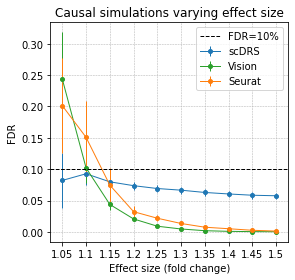

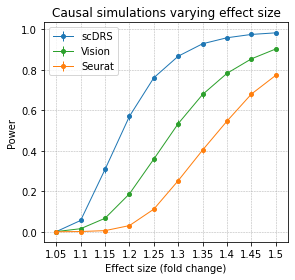

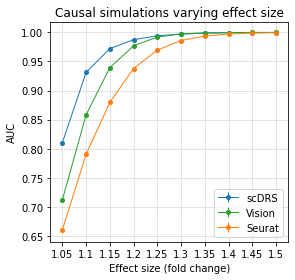

In [4]:
# Varying effect size 

plot_method_list = ['sctrs', 'vision', 'seurat']
default_overlap = 0.25
    
df_plot = pd.DataFrame(index=EFF_LIST, dtype=float)
df_plot_se = pd.DataFrame(index=EFF_LIST, dtype=float)

for eff in EFF_LIST:
    perturb = PERTURB_FILE.replace('@e', '%d'%int(eff*100)).replace('@o', '%d'%int(default_overlap*100))
    for method in plot_method_list:
        temp_v = dic_res['%s:%s'%(perturb,method)]['fdp'].values
        df_plot.loc[eff, '%s.fdp.mean'%method] = temp_v.mean()
        df_plot.loc[eff, '%s.fdp.se'%method] = temp_v.std()/np.sqrt(temp_v.shape[0])
        
        temp_v = dic_res['%s:%s'%(perturb,method)]['power'].values
        df_plot.loc[eff, '%s.power.mean'%method] = temp_v.mean()
        df_plot.loc[eff, '%s.power.se'%method] = temp_v.std()/np.sqrt(temp_v.shape[0])  
        
        temp_v = dic_res['%s:%s'%(perturb,method)]['auc'].values
        df_plot.loc[eff, '%s.auc.mean'%method] = temp_v.mean()
        df_plot.loc[eff, '%s.auc.se'%method] = temp_v.std()/np.sqrt(temp_v.shape[0])
df_plot.index += 1
    
# FDP&Power plot 
dic_ylabel={'fdp':'FDR', 'power':'Power', 'auc':'AUC'}
for term in ['fdp', 'power', 'auc']:
    plt.figure(figsize=[4.2,4])
    xmin,xmax = df_plot.index.min()-0.025,df_plot.index.max()+0.025
    if term=='fdp':
        plt.plot([xmin,xmax], [0.1, 0.1], linestyle='--', linewidth=1, color='k', zorder=10, label='FDR=10%')
    for method in plot_method_list:
        plt.errorbar(df_plot.index, df_plot['%s.%s.mean'%(method, term)], 
                     yerr = df_plot['%s.%s.se'%(method, term)]*1.96,
                     label = DIC_METHOD_NAME[method],
                     fmt='-o', linewidth=1, markersize=4, color=DIC_METHOD_COLOR[method])
    plt.xlim([xmin,xmax])
    plt.xticks(df_plot.index, df_plot.index)
    plt.xlabel('Effect size (fold change)')
    plt.ylabel(dic_ylabel[term])
    plt.grid(linestyle='--', linewidth=0.5)
    plt.title('Causal simulations varying effect size')
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PATH+'/varying_eff.%s.svg'%term)
    plt.show()
    
    # Store data for the main figure term=='power'
    if term=='power':
        SUPP_TAB_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/supp_table'
        df_out = df_plot[[x for x in df_plot.columns if 'power' in x]].copy()
        df_out.index.name='effect_size'
        df_out.to_csv(SUPP_TAB_PATH+'/supp_tab_fig2b.tsv', sep='\t')

In [5]:
for method in plot_method_list:
    print(method, (1.96*df_out['%s.power.se'%method]).max())

sctrs 0.018153827464307253
vision 0.015556753632724744
seurat 0.016881711763338116


In [6]:
df_out

,sctrs.power.mean,sctrs.power.se,vision.power.mean,vision.power.se,seurat.power.mean,seurat.power.se
effect_size,,,,,,
1.05,0.001270,0.000295,0.001453,0.000276,0.000328,0.000090
1.10,0.056472,0.003776,0.015593,0.001070,0.001662,0.000278
1.15,0.308825,0.008757,0.067199,0.002773,0.006054,0.000610
1.20,0.571100,0.009262,0.187903,0.005048,0.031017,0.002106
1.25,0.761607,0.006822,0.359814,0.006938,0.112243,0.004597
1.30,0.868127,0.004753,0.534968,0.007937,0.253224,0.006987
1.35,0.929605,0.003106,0.679006,0.007930,0.404242,0.008399
1.40,0.959222,0.001980,0.783508,0.006924,0.547455,0.008613
1.45,0.975619,0.001388,0.854972,0.005541,0.680961,0.008316


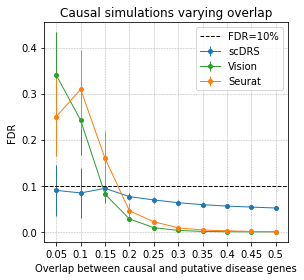

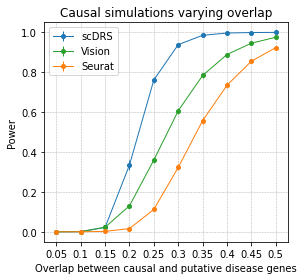

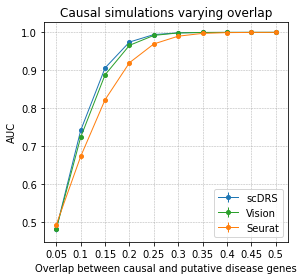

In [7]:
# Varying effect size 

plot_method_list = ['sctrs', 'vision', 'seurat']
default_eff = 0.25
    
df_plot = pd.DataFrame(index=OVERLAP_LIST, dtype=float)
df_plot_se = pd.DataFrame(index=OVERLAP_LIST, dtype=float)

for overlap in OVERLAP_LIST:
    perturb = PERTURB_FILE.replace('@e', '%d'%int(default_eff*100)).replace('@o', '%d'%int(overlap*100))
    for method in plot_method_list:
        temp_v = dic_res['%s:%s'%(perturb,method)]['fdp'].values
        df_plot.loc[overlap, '%s.fdp.mean'%method] = temp_v.mean()
        df_plot.loc[overlap, '%s.fdp.se'%method] = temp_v.std()/np.sqrt(temp_v.shape[0])
        
        temp_v = dic_res['%s:%s'%(perturb,method)]['power'].values
        df_plot.loc[overlap, '%s.power.mean'%method] = temp_v.mean()
        df_plot.loc[overlap, '%s.power.se'%method] = temp_v.std()/np.sqrt(temp_v.shape[0])  
        
        temp_v = dic_res['%s:%s'%(perturb,method)]['auc'].values
        df_plot.loc[overlap, '%s.auc.mean'%method] = temp_v.mean()
        df_plot.loc[overlap, '%s.auc.se'%method] = temp_v.std()/np.sqrt(temp_v.shape[0]) 

# FDP plot 
dic_ylabel={'fdp':'FDR', 'power':'Power', 'auc':'AUC'}
for term in ['fdp', 'power', 'auc']:
    plt.figure(figsize=[4.2,4])
    xmin,xmax = df_plot.index.min()-0.025,df_plot.index.max()+0.025
    if term=='fdp':
        plt.plot([xmin,xmax], [0.1, 0.1], linestyle='--', linewidth=1, color='k', zorder=10, label='FDR=10%')
    for method in plot_method_list:
        plt.errorbar(df_plot.index, df_plot['%s.%s.mean'%(method, term)], 
                     yerr = df_plot['%s.%s.se'%(method, term)]*1.96,
                     label = DIC_METHOD_NAME[method],
                     fmt='-o', linewidth=1, markersize=4, color=DIC_METHOD_COLOR[method])
    plt.xlim([xmin,xmax])
    plt.xticks(df_plot.index, df_plot.index)
    plt.xlabel('Overlap between causal and putative disease genes')
    plt.ylabel(dic_ylabel[term])
    plt.grid(linestyle='--', linewidth=0.5)
    plt.title('Causal simulations varying overlap')
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PATH+'/varying_overlap.%s.svg'%term)
    plt.show()
#     break